In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers, regularizers, models, layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16
from random import shuffle, randint
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
import os, shutil
from os import listdir
from os.path import isfile, join
from keras.models import load_model, model_from_json
from pathlib import Path
from file_utils import make_dir_helper, delete_dir_helper, is_jpeg

Using TensorFlow backend.


In [47]:
project_dir_name = 'Esri Project'
base_scripts_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'scripts');
model_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'models');

POSITIVE_CLASS = 'roads'
NEGATIVE_CLASS = 'others'
MODEL_FILE_NAME = POSITIVE_CLASS + '_model_road_detector.h5'
ext = '.jpg'
IMAGE_SIZE = 256
EPOCHS = 20
BATCH_SIZE = 10
STEPS_PER_EPOCH = 30

dataset_dir_name =   'redlands roads dataset'
original_dataset_dir = join(os.path.expanduser('~'),'Desktop', project_dir_name, 'datasets', dataset_dir_name);
positive_dataset_dir = join(original_dataset_dir, POSITIVE_CLASS)
negative_dataset_dir = join(original_dataset_dir, NEGATIVE_CLASS)

base_data_dir =  join(os.path.expanduser('~'), 'Desktop', project_dir_name, 'temp data');

train_dir = join(base_data_dir, 'train')
validation_dir = join(base_data_dir, 'validation')
test_dir = join(base_data_dir, 'test')
aug_dir = join(base_data_dir, 'augmented images')

model_file_path = join(model_dir, MODEL_FILE_NAME)

train_pos_dir = join(train_dir, POSITIVE_CLASS)
validation_pos_dir = join(validation_dir, POSITIVE_CLASS)
test_pos_dir = join(test_dir, POSITIVE_CLASS)

train_neg_dir = join(train_dir, NEGATIVE_CLASS)
validation_neg_dir = join(validation_dir, NEGATIVE_CLASS)
test_neg_dir = join(test_dir, NEGATIVE_CLASS)

In [40]:
delete_dir_helper(base_data_dir)

# Make base directories
make_dir_helper(base_data_dir)
make_dir_helper(train_dir)
make_dir_helper(validation_dir)
make_dir_helper(test_dir)
make_dir_helper(model_dir)
make_dir_helper(aug_dir)

# Make positive class sub directories
make_dir_helper(train_pos_dir)
make_dir_helper(validation_pos_dir)
make_dir_helper(test_pos_dir)

# Make negative class sub directories
make_dir_helper(train_neg_dir)
make_dir_helper(validation_neg_dir)
make_dir_helper(test_neg_dir)

True

In [43]:
fnames = [f for f in listdir(positive_dataset_dir) if isfile(join(positive_dataset_dir, f))]
shuffle(fnames)

no_samples = len(fnames)
no_training_samples = round(no_samples * .70)

for idx, fname in enumerate(fnames):
    
    src_dir = os.path.join(positive_dataset_dir, fname)
    if idx < no_training_samples:
        
        dst_dir = os.path.join(train_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
    
    elif no_training_samples <= idx < no_samples:
        
        dst_dir = os.path.join(validation_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        
        dst_dir = os.path.join(test_pos_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

In [44]:
fnames = [f for f in os.listdir(negative_dataset_dir) if isfile(join(negative_dataset_dir, f))]
shuffle(fnames)

no_samples = len(fnames)
no_training_samples = int(no_samples * .70)
  
for idx, fname in enumerate(fnames):
    
    src_dir = os.path.join(negative_dataset_dir, fname)
    if idx < no_training_samples:
        
        dst_dir = os.path.join(train_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        
    elif no_training_samples <= idx < no_samples:
        
        dst_dir = os.path.join(validation_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)
        dst_dir = os.path.join(test_neg_dir, fname)
        shutil.copyfile(src_dir, dst_dir)

In [45]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   vertical_flip=True,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)   

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(IMAGE_SIZE, IMAGE_SIZE),  
        batch_size=BATCH_SIZE,
        class_mode='binary')  

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')

Found 2570 images belonging to 2 classes.
Found 1102 images belonging to 2 classes.


In [46]:
model = models.Sequential()
conv_base = VGG16(weights='imagenet' ,include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

for layer in conv_base.layers:
    if 'block_5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False


model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])
conv_base.summary()

callbacks = [
    EarlyStopping(monitor='acc', patience=3, mode='auto'),
    ModelCheckpoint(monitor='val_loss', save_best_only=True, filepath=model_file_path)
]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

Epoch 1/20
30/30 [==============================] - 149s - loss: 1.0749 - acc: 0.5533 - val_loss: 0.7321 - val_acc: 0.7100
Epoch 2/20
30/30 [==============================] - 144s - loss: 0.7900 - acc: 0.6733 - val_loss: 0.7215 - val_acc: 0.7067
Epoch 3/20
30/30 [==============================] - 151s - loss: 0.7300 - acc: 0.7100 - val_loss: 0.6092 - val_acc: 0.7933
Epoch 4/20
30/30 [==============================] - 153s - loss: 0.7094 - acc: 0.6867 - val_loss: 0.6070 - val_acc: 0.7133
Epoch 5/20
30/30 [==============================] - 151s - loss: 0.6283 - acc: 0.7467 - val_loss: 0.6481 - val_acc: 0.7367
Epoch 6/20
30/30 [==============================] - 151s - loss: 0.6229 - acc: 0.7400 - val_loss: 0.4685 - val_acc: 0.8390
Epoch 7/20
30/30 [==============================] - 145s - loss: 0.5822 - acc: 0.7200 - val_loss: 0.4986 - val_acc: 0.8267
Epoch 8/20
30/30 [==============================] - 144s - loss: 0.5284 - acc: 0.8233 - val_loss: 0.4798 - val_acc: 0.8533
Epoch 9/20
30/30

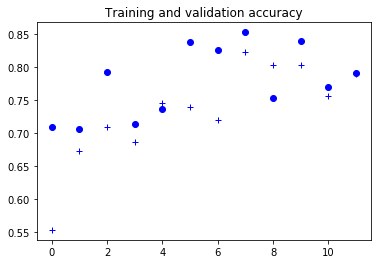

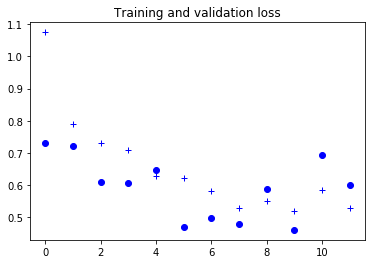

In [48]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=STEPS_PER_EPOCH,
      epochs=EPOCHS,
      callbacks = callbacks,
      validation_data=validation_generator,
      validation_steps=STEPS_PER_EPOCH)

model.save(model_file_path) 

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b+')
plt.plot(epochs, val_acc, 'bo')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'b+')
plt.plot(epochs, val_loss, 'bo')
plt.title('Training and validation loss')

plt.show()

In [15]:
fnames = []
target_dir = test_dir
dnames = [join(target_dir, dname) for dname in listdir(target_dir)]

for dname in dnames:
    
    fnames =([join(dname, fname) for fname in listdir(dname)])
    
    cur_class = dname.split('\\')[-1]
    print(cur_class, end=':- ')

    correct_predict_count = 0
    high_accuracy_count = 0
    
    for index, img_path in enumerate(fnames):
          
        img = image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)) 
        
        img_tensor = image.img_to_array(img)
        img_tensor = img_tensor.reshape((1,) + img_tensor.shape)
        img_tensor /= 255.
        prediction = model.predict(img_tensor)[0]
        
        print(prediction)
        if cur_class == 'others':
            if prediction[0] <= 0.5:
                correct_predict_count +=1
        else:
            if prediction[0] > 0.5:
                correct_predict_count +=1

          
    print('Accuracy: ' + str(correct_predict_count / len(fnames) * 100) + ' , High count: ' + str(high_accuracy_count))
    

others:- [ 0.10735992]
[ 0.03734896]
[ 0.20133434]
[ 0.26532114]
[ 0.3416976]
[ 0.02447155]
[ 0.06888978]
[ 0.01225081]
[ 0.14490685]
[ 0.11808667]
[ 0.01863642]
[ 0.2819337]
[ 0.04254561]
[ 0.11313225]
[ 0.02817493]
[ 0.20038208]
[ 0.03772009]
[ 0.03654425]
[ 0.11054202]
[ 0.12504002]
[ 0.07346115]
[ 0.05213671]
[ 0.02386849]
[ 0.14623845]
[ 0.09853201]
[ 0.01575755]
[ 0.00520377]
[ 0.26110357]
[ 0.06347521]
[ 0.04526196]
[ 0.0821723]
[ 0.03277256]
[ 0.01605828]
[ 0.00082498]
[ 0.00073573]
[ 0.01629856]
[ 0.04621963]
[ 0.06067204]
[ 0.14033768]
[ 0.15731575]
[ 0.33965749]
[ 0.11392654]
[ 0.03316855]
[ 0.19207714]
[ 0.11917584]
[ 0.01726894]
[ 0.01456599]
[ 0.01459977]
[ 0.39750504]
[ 0.21307094]
[ 0.02134351]
[ 0.03030663]
[ 0.02077116]
[ 0.04020667]
[ 0.05484914]
[ 0.27093565]
[ 0.34306273]
[ 0.00592623]
[ 0.00674804]
[ 0.02156961]
[ 0.10132354]
[ 0.12597868]
[ 0.01389016]
[ 0.00190083]
[ 0.01105428]
[ 0.00790028]
[ 0.02043047]
[ 0.07505859]
[ 0.00123448]
[ 0.00101211]
[ 0.0884204]
[

[ 0.04131522]
[ 0.03213257]
[ 0.06304496]
[ 0.22302648]
[ 0.01367613]
[ 0.05294565]
[ 0.04753049]
[ 0.14494933]
[ 0.24015749]
[ 0.04614625]
[ 0.43938273]
[ 0.31820366]
[ 0.0042265]
[ 0.28833306]
[ 0.08246708]
[ 0.15202762]
[ 0.11166313]
[ 0.09159273]
[ 0.13792305]
[ 0.02046184]
[ 0.09730574]
[ 0.82535088]
[ 0.45332476]
[ 0.0932597]
[ 0.33063942]
[ 0.71054471]
[ 0.0633985]
[ 0.04540596]
[ 0.06846246]
[ 0.41832614]
[ 0.39480031]
[ 0.14004205]
[ 0.0987877]
[ 0.40669569]
[ 0.28651628]
[ 0.00730252]
[ 0.06773596]
[ 0.10398059]
[ 0.10677647]
[ 0.28636602]
[ 0.1030788]
[ 0.36456427]
[ 0.01922292]
[ 0.02347346]
[ 0.01634799]
[ 0.02372641]
[ 0.1027559]
[ 0.0207465]
[ 0.0378398]
[ 0.03915633]
[ 0.02672169]
[ 0.06741774]
[ 0.01245409]
[ 0.1055508]
[ 0.00589623]
[ 0.03489563]
[ 0.01669521]
[ 0.03856407]
[ 0.32543132]
[ 0.0717618]
[ 0.06633055]
[ 0.17365953]
[ 0.10523244]
[ 0.11291295]
[ 0.5343855]
[ 0.30324614]
[ 0.20995089]
[ 0.0665395]
[ 0.0791749]
[ 0.00146292]
[ 0.00441147]
[ 0.31417713]
[ 0.0

In [49]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        classes = ['roads'],
        save_to_dir=aug_dir,
        save_format='jpeg',
        class_mode=None)
predictions = model.predict_generator(test_generator, 40, max_queue_size=10, workers=8, use_multiprocessing=False, verbose=0)

Found 400 images belonging to 1 classes.


In [53]:
predictions = np.asarray(predictions).flatten()
correct_count = 0

for idx, x in enumerate(predictions):
    if x > 0.4:
        correct_count += 1
    else:
        print(idx , x)
print(correct_count / len(predictions) * 100)

4 0.0831203
7 0.286814
8 0.141508
11 0.339247
12 0.0251936
13 0.0664835
15 0.0484201
16 0.355023
19 0.0787004
22 0.310274
25 0.381461
26 0.0145345
27 0.0726902
28 0.112223
29 0.0194847
30 0.37301
38 0.164888
42 0.249246
45 0.0230143
47 0.137509
52 0.394114
53 0.253676
55 0.0413104
58 0.33397
59 0.208736
64 0.336376
67 0.230184
70 0.328721
74 0.00202129
76 0.0483437
78 0.0897968
80 0.320053
81 0.164496
83 0.328461
85 0.0492584
86 0.0604332
88 0.297525
89 0.237294
93 0.0377923
96 0.0104647
97 0.00991094
99 0.0224118
100 0.214161
101 0.282964
102 0.23476
106 0.0346347
109 0.185972
111 0.013445
113 0.370917
114 0.366345
115 0.174537
116 0.0220537
118 0.0627505
122 0.0439572
127 0.220089
133 0.253995
145 0.11128
146 0.164219
148 0.372798
149 0.0104601
150 0.051243
152 0.191042
153 0.0525736
158 0.269985
159 0.275224
160 0.1622
162 0.0453159
163 0.301151
164 0.0824496
165 0.340158
168 0.00960873
171 0.248417
180 0.0784648
181 0.18711
182 0.0227989
183 0.0397903
195 0.340237
197 0.0274469
199